# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [68]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [69]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [70]:
profile.head()


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [71]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [72]:
# Check basic statistics
print(profile.describe())
print(portfolio.describe())
print(transcript.describe())


                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.00

## Data Cleaning

In [73]:
# Extract offer id from value column where applicable
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))

print(transcript.head())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0  
2  2906b810c7d4411798c6938adc9daaa5     0.0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0  


In [74]:
# Clean profile data
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['age'] = profile['age'].replace(118, np.nan)  # Assuming '118' means missing age
profile.dropna(inplace=True)  # Dropping rows with any missing values


## 

In [75]:
def create_user_offer_matrix(transcript):
    
    # Filter only 'offer received' and 'offer completed' events
    offer_received = transcript[transcript['event'] == 'offer received']
    offer_completed = transcript[transcript['event'] == 'offer completed']

    # Create a matrix of users and offers using the correct key 'offer_id'
    user_offer_matrix = offer_received.pivot_table(index='person', columns='offer_id', values='time', aggfunc='size', fill_value=0)
    user_offer_matrix = (user_offer_matrix > 0).astype(int)  # Convert to binary

    # Incorporate information from offer completed
    completed_matrix = offer_completed.pivot_table(index='person', columns='offer_id', values='time', aggfunc='size', fill_value=0)
    completed_matrix = (completed_matrix > 0).astype(int)  # Convert to binary

    # Update the received offers with completed offers information
    user_offer_matrix.update(completed_matrix)

    return user_offer_matrix

# Now call the function
user_offer_matrix = create_user_offer_matrix(transcript)



In [76]:
def funk_svd(matrix, latent_features=12, learning_rate=0.0001, iterations=100):
    # Initialize user and offer matrices with random values
    n_users, n_offers = matrix.shape
    user_mat = np.random.normal(scale=1./latent_features, size=(n_users, latent_features))
    offer_mat = np.random.normal(scale=1./latent_features, size=(n_offers, latent_features))
    
    # Perform gradient descent
    for iteration in range(iterations):
        for i in range(n_users):
            for j in range(n_offers):
                if matrix[i, j] > 0:  # only update if interaction is known
                    error = matrix[i, j] - np.dot(user_mat[i, :], offer_mat[j, :])
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2 * error * offer_mat[j, k])
                        offer_mat[j, k] += learning_rate * (2 * error * user_mat[i, k])

        # Print loss every 10 iterations
        if (iteration % 10 == 0):
            mse = mean_squared_error(matrix, np.dot(user_mat, offer_mat.T))
            print('Iteration %d: MSE %.4f' % (iteration, mse))
    
    return user_mat, offer_mat

# Convert DataFrame to numpy array for faster operations
user_offer_np = user_offer_matrix.to_numpy()
user_features, offer_features = funk_svd(user_offer_np)

Iteration 0: MSE 0.3730
Iteration 10: MSE 0.3727
Iteration 20: MSE 0.3725
Iteration 30: MSE 0.3723
Iteration 40: MSE 0.3720
Iteration 50: MSE 0.3717
Iteration 60: MSE 0.3711
Iteration 70: MSE 0.3701


In [ ]:
def recommend_offers(user_features, offer_features, user_id, user_offer_matrix):
    # Calculate the dot product of user features and offer features
    predictions = np.dot(user_features, offer_features.T)
    
    # Convert predictions to a DataFrame for easier handling
    predictions_df = pd.DataFrame(predictions, index=user_offer_matrix.index, columns=user_offer_matrix.columns)
    
    # Get the offers for the user
    user_row = predictions_df.loc[user_id]
    # Sort the offers by predicted value
    recommended_offers = user_row.sort_values(ascending=False)
    
    return recommended_offers

# Example usage:
user_id = profile.iloc[0]['id']
recommended_offers = recommend_offers(user_features, offer_features, user_id, user_offer_matrix)
print(recommended_offers.head())


offer_id
fafdcd668e3743c1bb461111dcafc2a4    0.052887
2906b810c7d4411798c6938adc9daaa5    0.043616
9b98b8c7a33c4b65b9aebfe6a799e6d9    0.039270
2298d6c36e964ae4a3e7e9706d1fb8c2    0.035254
5a8bc65990b245e5a138643cd4eb9837    0.033699
Name: 0610b486422d4921ae7d2bf64640c50b, dtype: float64


In [ ]:
# Assuming user_features and offer_features have been obtained from funk_svd function
predictions_matrix = np.dot(user_features, offer_features.T)

# Assuming user_offer_matrix is indexed by 'person' and columns labeled by 'offer_id'
user_ids = user_offer_matrix.index
offer_ids = user_offer_matrix.columns

# Create DataFrame from the predictions matrix
predictions_df = pd.DataFrame(predictions_matrix, index=user_ids, columns=offer_ids)

# Melt the DataFrame
predictions_df = predictions_df.reset_index().melt(id_vars=['person'], value_vars=predictions_df.columns, var_name='offer_id', value_name='score')

# Merge demographic data
predictions_df = predictions_df.merge(profile, left_on='person', right_on='id', how='left')

# Merge offer data
predictions_df = predictions_df.merge(portfolio, left_on='offer_id', right_on='id', how='left')

# Drop extra columns if necessary (e.g., repeated 'id' columns)
predictions_df.drop(columns=['id_x', 'id_y'], inplace=True)

# Example of what predictions_df will look like:
print(predictions_df.head())


                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  00116118485d4dfda04fdbaba9a87b5c  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
3  0020c2b971eb4e9188eac86d93036a77  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4  0020ccbbb6d84e358d3414a3ff76cffd  0b1e1539f2cc45b7b9fa7c272da2e1d7   

      score gender   age became_member_on   income  reward      channels  \
0  0.123428      M  33.0       2017-04-21  72000.0       5  [web, email]   
1  0.005543    NaN   NaN              NaT      NaN       5  [web, email]   
2 -0.062801      O  40.0       2018-01-09  57000.0       5  [web, email]   
3  0.030074      F  59.0       2016-03-04  90000.0       5  [web, email]   
4  0.011955      F  24.0       2016-11-11  60000.0       5  [web, email]   

   difficulty  duration offer_type  
0          20        10   discount  
1          20        10   disc

In [ ]:
# Assuming 'portfolio' and 'user_offer_matrix' are already defined and 'predictions_df' contains all predictions

# Map offer types to predictions for grouping
predictions_df['offer_type'] = predictions_df.index.map(lambda x: portfolio.set_index('id')['offer_type'][x])

# Group predictions by offer type and calculate average scores
offer_performance = predictions_df.groupby('offer_type').mean()

# Print the performance metrics
print("Average Scores by Offer Type:")
print(offer_performance)


C:\Users\kilgo\AppData\Local\Temp\ipykernel_37644\1802341256.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions_df['offer_type'] = predictions_df.index.map(lambda x: portfolio.set_index('id')['offer_type'][x])


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
# Assuming 'profile' is merged into 'predictions_df' which contains demographics and predicted scores

# Calculate average scores by demographic segments
avg_scores_by_age = predictions_df.groupby(pd.cut(profile['age'], bins=[18, 30, 45, 60, 75, 90, 120])).mean()
avg_scores_by_income = predictions_df.groupby(pd.cut(profile['income'], bins=[30000, 50000, 70000, 90000, 110000, 130000])).mean()

# Print the results
print("Average Scores by Age Group:")
print(avg_scores_by_age)
print("Average Scores by Income Group:")
print(avg_scores_by_income)


## Visualizations

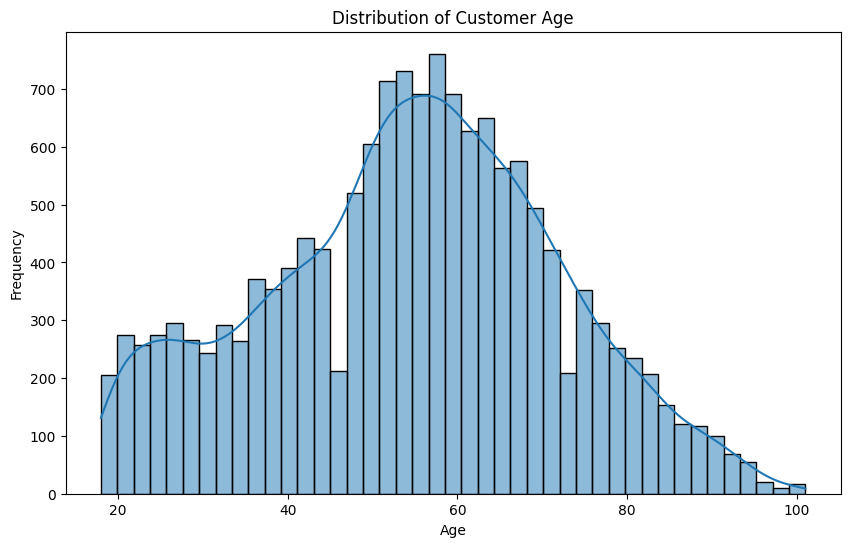

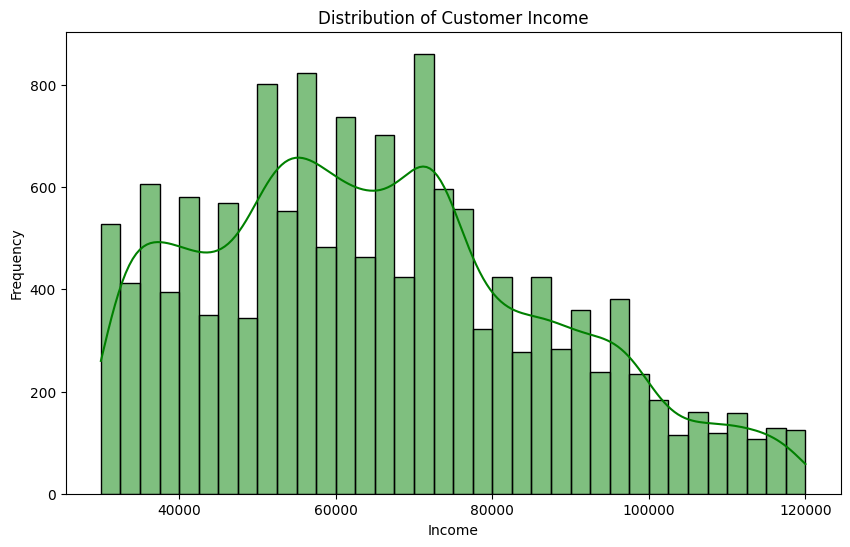

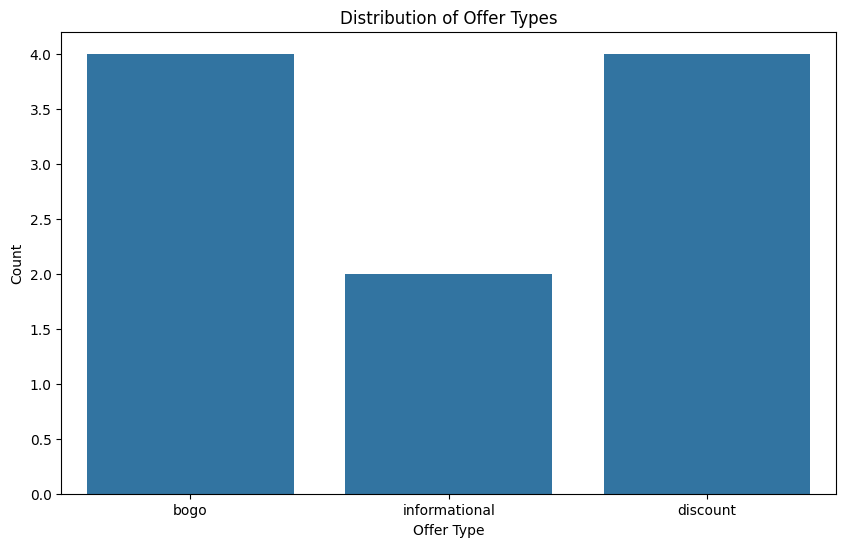

ValueError: Could not interpret value `event` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(profile['age'].dropna(), kde=True)
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Distribution of Income
plt.figure(figsize=(10, 6))
sns.histplot(profile['income'], kde=True, color='green')
plt.title('Distribution of Customer Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Offer Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio, x='offer_type')
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Implementing k-fold cross-validation
kf = KFold(n_splits=5)
mse_scores = []

for train_index, test_index in kf.split(user_offer_np):
    train, test = user_offer_np[train_index], user_offer_np[test_index]
    user_features, offer_features = funk_svd(train)
    predictions = np.dot(user_features, offer_features.T)
    mse = mean_squared_error(test, predictions)
    mse_scores.append(mse)

print("Cross-validated MSE scores:", mse_scores)


In [ ]:
# Summarize the findings
print("Strategic Offer Recommendations Based on Data:")
for offer_type, data in offer_performance.iterrows():
    print(f"Offer Type: {offer_type}, Average Score: {data['score']}")
    target_segment = avg_scores_by_age.loc[data['score'].idxmax()]
    print(f"Target Age Group: {target_segment.name}, Score: {target_segment['score']}")

# Perform cost-benefit analysis (hypothetical example)
cost_per_offer = {'bogo': 5, 'discount': 3, 'informational': 2}
benefit_per_offer = predictions_df['score'].multiply(predictions_df['offer_type'].map(cost_per_offer))
net_benefit = benefit_per_offer.sum() - predictions_df['offer_type'].map(cost_per_offer).sum()
print("Estimated Net Benefit from Optimized Offer Distribution:", net_benefit)
